In [1]:
import os
import sys


import argparse
import numpy as np


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from utils.waymo_motion_dataset2 import waymo_motion_dataset, collate

from utils.VectorNet import SubGraph, GNN
from utils.MTP_loss import multi_mode_loss_L2
from utils.Joint_metric import min_K_joint_ADE_metric
from utils.Decoder3 import Decoder

import math
import os
import uuid
import time
import torch

from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import numpy as np
from IPython.display import HTML
import itertools
import tensorflow.compat.v1 as tf

from google.protobuf import text_format
from waymo_open_dataset.metrics.ops import py_metrics_ops
from waymo_open_dataset.metrics.python import config_util_py as config_util
from waymo_open_dataset.protos import motion_metrics_pb2


In [2]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
    extras = {"num_workers": len(os.sched_getaffinity(0)), "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    device = torch.device("cpu")
    extras = {"num_workers": len(os.sched_getaffinity(0)), "pin_memory": False}
    print("CUDA NOT supported")

CUDA is supported


In [3]:
train_path_ = '/datasets-2/waymo/uncompressed/tf_example/validation_interactive/'

In [4]:
train_dataset = waymo_motion_dataset(dataroot = train_path_,
                                         scene_list = range(25,26))
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = 1,
                          shuffle = True,
                          collate_fn = collate,
                          num_workers = 8,
                          pin_memory = extras['pin_memory'])

  0%|          | 0/1 [00:00<?, ?it/s]

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [8]:

# Define subgraph propagation networks
N_hidden = 64
# Agent vector is 9
# [x, y, z, one-hot-type (5), id]
agent_subgraph = SubGraph(8, N_hidden)
# Roadmap vector is 27
# [x, y, z, dir_x, dir_y, dir_z, one-hot-type (20), id]
roadmap_subgraph = SubGraph(26, N_hidden)
# Define global interaction graph

# Define decoder
N_modes = 3
T = 80
decoder = Decoder(N_hidden + 5, N_modes, T)
agent_subgraph = agent_subgraph.to(device)
roadmap_subgraph = roadmap_subgraph.to(device)
decoder = decoder.to(device)

model = torch.load('/home/sghosal/working_models/model_agent_subraph_only.pt')
agent_subgraph.load_state_dict(model['agent_subgraph'])
decoder.load_state_dict(model['decoder'])

<All keys matched successfully>

In [9]:
Loss = 0

for minibatch_count, data in enumerate(tqdm(train_loader)):

    agents_polylines, agents_polylines_mask, \
    roadgraph_polylines, roadgraph_polylines_mask, \
    targets, targets_mask,\
    tracks_to_predict, objects_of_interest,\
    agents_motion = data

    batch_size, num_agents, num_steps, dim_agent_vec = agents_polylines.shape
    _, num_max_roads, num_max_road_length, dim_road_vec = roadgraph_polylines.shape

    agents_polylines, agents_polylines_mask = agents_polylines.to(device), agents_polylines_mask.to(device)
    roadgraph_polylines, roadgraph_polylines_mask = roadgraph_polylines.to(device), roadgraph_polylines_mask.to(device)
    targets, targets_mask = targets.to(device), targets_mask.to(device)
    agents_motion = agents_motion.to(device)

    agent_polyline_features = agent_subgraph(agents_polylines[:, :, :, :8],
                                             agents_polylines_mask,
                                             agents_polylines.shape[1], agents_polylines.shape[2])
    '''
    roadgraph_polyline_features = roadmap_subgraph(roadgraph_polylines[:, :, :, :26], 
                                                   roadgraph_polylines_mask,
                                                   roadgraph_polylines.shape[1], roadgraph_polylines.shape[2])
    '''

    agent_feature_mask = torch.any(agents_polylines_mask, dim = 2)
    #roadgraph_feature_mask = torch.any(roadgraph_polylines_mask, dim = 2)

    graph_output = agent_polyline_features
    loss = 0

    # Decode and compute loss scene by scene
    for s in range(batch_size):
        agent_inds = torch.nonzero((objects_of_interest == 1)[s,:], as_tuple=True)[0]
        num_tracks_to_predict = agent_inds.shape[0]

#                 for ind in agent_inds:
# #                     target_features = agent_polyline_features[s, [ind.item()], :]
#                     target_features = torch.cat([agent_polyline_features[s, [ind.item()], :], 
#                                                  agents_motion[s, [ind.item()], :]], dim = 1)
#     #                 target_features = torch.cat([graph_output[s,agent_inds,:], 
#     #                                              agent_polyline_features[s, agent_inds, :]], dim = 1)
#     #                 target_features = graph_output[s, agent_inds, :]
#     #                 target_features = torch.cat(trainable_params = list(agent_subgraph.parameters()) \
#     #                                              agents_polylines[s, agent_inds, 0, : 2],
#     #                                              agents_motion[s, agent_inds, :]], dim = 1)
#                     decoded_traj, decoded_probs = decoder(target_features)
#                     ground_truth = targets[s, [ind.item()], :, :2]

#                     pos_loss, log_loss, pos_loss_10 = multi_mode_loss_L2(decoded_traj, decoded_probs, ground_truth)
#                     loss = loss + pos_loss + log_loss
#                     pos_loss_total += pos_loss
#                     pos_loss_10_total += pos_loss_10

#                 target_features = agent_polyline_features[s, agent_inds, :]
#                 target_features = torch.cat([agent_polyline_features[s, agent_inds, :], 
#                                              agents_motion[s, agent_inds, :]], dim = 1)
#                 target_features = torch.cat([agent_polyline_features[s, agent_inds, :], 
#                                              agents_polylines[s, agent_inds, 0, : 2],
#                                              agents_motion[s, agent_inds, :]], dim = 1)
#                target_features = torch.cat([graph_output[s,agent_inds,:], 
#                                              agent_polyline_features[s, agent_inds, :]], dim = 1)
#                target_features = graph_output[s, agent_inds, :]
        target_features = torch.cat([graph_output[s, agent_inds, :], 
                                      agents_polylines[s, agent_inds, 0, : 2],
                                      agents_motion[s, agent_inds, :]], dim = 1)
        decoded_traj, decoded_probs = decoder(target_features)
        ground_truth = targets[s,agent_inds,:,0:2]

        loss,entropy_loss = multi_mode_loss_L2(decoded_traj, decoded_probs, ground_truth)
        loss = loss + entropy_loss



    loss = loss / batch_size / num_tracks_to_predict


    Loss+=loss
print('Epoch Loss: {}'.format(Loss / (len(train_dataset))))


100%|██████████| 150/150 [00:06<00:00, 23.65it/s]

Epoch Loss: tensor([9.2289], device='cuda:0', grad_fn=<DivBackward0>)


In [26]:
mode = np.argmax(decoded_probs.cpu().detach().numpy())
print(mode)

1


In [27]:
print(torch.cat([decoded_traj[0][mode].cpu(),ground_truth[0].cpu()],axis = 1))
print("-----------***------------")
print(torch.cat([decoded_traj[1][mode].cpu(),ground_truth[1].cpu()],axis = 1))

tensor([[-1.7222e+00, -1.1274e+01, -1.9827e+00, -1.1492e+01],
        [-1.6374e+00, -1.0149e+01, -1.9119e+00, -1.0371e+01],
        [-1.4735e+00, -9.0687e+00, -1.8516e+00, -9.2564e+00],
        [-1.4773e+00, -7.9067e+00, -1.7891e+00, -8.1295e+00],
        [-1.4442e+00, -6.8227e+00, -1.7285e+00, -7.0071e+00],
        [-1.3027e+00, -5.7054e+00, -1.6846e+00, -5.8884e+00],
        [-1.3217e+00, -4.5661e+00, -1.6357e+00, -4.7645e+00],
        [-1.1658e+00, -3.5283e+00, -1.5896e+00, -3.6365e+00],
        [-9.8606e-01, -2.4277e+00, -1.5513e+00, -2.5079e+00],
        [-9.5834e-01, -1.3880e+00, -1.5122e+00, -1.3864e+00],
        [-8.7166e-01, -1.9628e-01, -1.4751e+00, -2.8394e-01],
        [-7.7262e-01,  7.0305e-01, -1.4373e+00,  8.3124e-01],
        [-6.7586e-01,  1.7563e+00, -1.4026e+00,  1.9531e+00],
        [-6.0425e-01,  2.7602e+00, -1.3740e+00,  3.0754e+00],
        [-5.1949e-01,  3.8552e+00, -1.3403e+00,  4.2026e+00],
        [-4.5266e-01,  4.8162e+00, -1.3086e+00,  5.3450e+00],
        

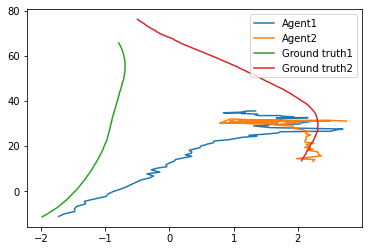

In [28]:
plt.plot(decoded_traj.cpu().detach().numpy()[0,mode,:,0],decoded_traj.cpu().detach().numpy()[0,mode,:,1], label='Agent1')
plt.plot(decoded_traj.cpu().detach().numpy()[1,mode,:,0],decoded_traj.cpu().detach().numpy()[1,mode,:,1], label='Agent2')
plt.plot(ground_truth.cpu().detach().numpy()[0,:,0],ground_truth.cpu().detach().numpy()[0,:,1], label='Ground truth1')
plt.plot(ground_truth.cpu().detach().numpy()[1,:,0],ground_truth.cpu().detach().numpy()[1,:,1], label='Ground truth2')
plt.legend()
plt.show()

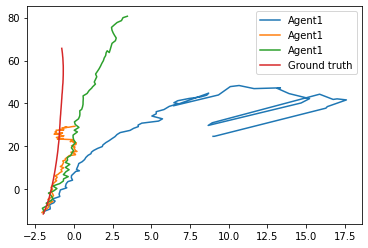

In [23]:

plt.plot(decoded_traj.cpu().detach().numpy()[0,0,:,0],decoded_traj.cpu().detach().numpy()[0,0,:,1], label='Agent1')
plt.plot(decoded_traj.cpu().detach().numpy()[0,1,:,0],decoded_traj.cpu().detach().numpy()[0,1,:,1], label='Agent1')
plt.plot(decoded_traj.cpu().detach().numpy()[0,2,:,0],decoded_traj.cpu().detach().numpy()[0,2,:,1], label='Agent1')
plt.plot(ground_truth.cpu().detach().numpy()[0,:,0],ground_truth.cpu().detach().numpy()[0,:,1],label='Ground truth')
plt.legend()
plt.show()


In [ ]:
decoded_probs

In [ ]:
list(decoded_probs.cpu().detach().numpy())